# Audio Similarity Search

In this notebook we'll build a content-based audio similarity search system: given a short sound clip, we turn it into a vector embedding with a pretrained audio-tagging model, store those vectors in a Pinecone index, and then retrieve the most relevant results.

Audio similarity search systems are used in various fields. In music tech, they suggest tracks with a similar timbre or texture to a seed clip, helping build cohesive playlists and spot near-duplicates in catalogs. In post-production for film/TV, game studios and podcast teams, they let editors search huge SFX libraries by "sound-alike" to quickly find alternate takes or variations, even when filenames or tags are inconsistent. In contact centers and QA/compliance, they automatically flag recurring audio motifs across thousands of calls such as hold music, IVR beeps, or alarm tones so teams can monitor policy adherence, improve customer experience and streamline auditing.

# Setup: Installing Required Libraries

Before we begin, we need to install the necessary Python libraries. Run the cell below to install all dependencies for this notebook.

In [ ]:
# Install required libraries
!pip install -q ipython ipywidgets tqdm "numpy>=2.0.0" "pandas>=2.0.0,<3.0.0" librosa==0.10.2 \
    datasets==3.2.0 "torch>=2.5.1" "torchaudio>=2.5.1" \
    soundfile pinecone==5.4.2 panns-inference==0.1.0 requests

print("✅ All libraries installed successfully!")

# 1. Loading the Data

We'll be working with the ESC-50 (Environmental Sound Classification 50) dataset, which contains 2000 sounds spanning 50 semantic classes such as "chirping_birds", "crow" and "fireworks".

> Data source: https://huggingface.co/datasets/ashraq/esc50

In [ ]:
import numpy as np
import pandas as pd
import os

from pinecone import Pinecone, ServerlessSpec

# For loading and analysing audio files
import librosa
from IPython.display import Audio, display
import IPython.display as ipd
from IPython.display import Audio as Ipa

# Library that provides audio embedding models and reference tools for generating vectors
import panns_inference

# For progress bar
from tqdm.notebook import tqdm

from datasets import load_dataset
from datasets import Audio

import torch

In [ ]:
data = load_dataset("ashraq/esc50", split = "train")

Let's preview the data in a DataFrame. There are several columns:

- filename: the WAV file name
- fold: integer indicating cross‑validation fold (1–5)
- target: numeric class ID (0–49)
- category: human‑readable sound label
- esc10: boolean flag if it's part of the 10‑class ESC‑10 subset
- src_file: original source identifier
- take: version or fragment label
- audio: decoded audio data object including duration and samples


In [ ]:
preview_df = pd.DataFrame({c: data[c][:5] for c in data.column_names})
preview_df

We'll display 1 audio file that we are selecting using its index from "data". In the result below, we can see:
- `data (shape)`: 1 means there's one audio channel (mono), and the total number of samples is 220 500
- `duration_seconds`: the audio is 5 seconds long
- `sample_rate`: 44 100 measurements (samples) per second were taken when recording (this is a standard for high-quality audio)

In [ ]:
audio_dec = data[10]["audio"]
# Extract the audio array and sampling rate
audio_array = audio_dec['array']
sampling_rate = audio_dec['sampling_rate']

print(f"Audio shape: {audio_array.shape}")
print(f"Duration (seconds): {len(audio_array) / sampling_rate:.2f}")
print(f"Sampling rate: {sampling_rate} Hz")

When we look at the audio array, we're seeing the raw waveform. It is a long list of floating-point amplitudes (volume levels) between -1.0 and 1.0.

- positive values: parts of the wave that move upward
- negative values: parts of the wave that move downward
- values near zero: moments of silence or very low volume

In [ ]:
# Display first 10 audio samples
audio_array[:10]

# 2. Playing the Audio file

Let's play the audio file so we can hear what is acutally sounds like. We'll extract its waveform array and then use Ipython's `Audio` widget to play it directly in the notebook:

In [ ]:
# Choosing index (from 0 to 1999)
sound_num = 10

# Taking the "array" tha represents the actual sound
sound_array = data[sound_num]["audio"]['array']

# Printing the category of sound
print(data[sound_num]["category"])

# Playing
ipd.Audio(sound_array, rate = 44100)

# 3. Initializing the Auto-Tagging Model for Embeddings

Next, we will initialize **AudioTagging model** from `panns_inference` library. This model is based on PANNs (Pretrained Audio Neural Networks), a family of convolutional neural networks trained on the large-scale AudioSet dataset. The model takes an audio waveform as input and produce **2048-dimensional embedding vector**.

The code below will:
1. Download the pretrained model checkpoint (~81 MB) with a **progress bar** using Python's `requests` library
2. Load the model into memory

**Expected download time**: 30 seconds to 2 minutes (depending on your network speed)

> **Note**: The download happens only once. If you re-run this cell, it will skip the download if the file already exists. No system tools like `wget` are required - everything is handled by Python!

In [ ]:
import os
import time
import requests
from tqdm import tqdm
from panns_inference import AudioTagging

# Model Citation: PANNs Cnn14 from Kong et al. (2019)
# Source: https://zenodo.org/record/3987831 | DOI: 10.5281/zenodo.3987831 | License: MIT

# Remove potentially corrupted checkpoint file if it exists
checkpoint_path = '/root/panns_data/Cnn14_mAP=0.431.pth'
checkpoint_dir = '/root/panns_data'

if os.path.exists(checkpoint_path):
    print(f"Removing existing checkpoint: {checkpoint_path}")
    os.remove(checkpoint_path)
    print("Checkpoint removed. Will re-download...\n")

# Create directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Manual download with progress bar (faster and more visible)
model_url = 'https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth?download=1'

if not os.path.exists(checkpoint_path):
    print("Downloading model checkpoint (81 MB)...")
    print("This may take 30 seconds to 2 minutes depending on your connection.\n")
    
    response = requests.get(model_url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(checkpoint_path, 'wb') as f, tqdm(
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
        desc="Downloading"
    ) as pbar:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
            pbar.update(len(chunk))
    
    print("\n✅ Download complete!")
else:
    print("✅ Checkpoint already exists!")

# Load the model
print("\nLoading AudioTagging model...")
model = AudioTagging(checkpoint_path=checkpoint_path)
print("✅ Model loaded successfully!")

We will resample all clips to 32 kHz because the PANNs checkpoint was trained at 32 kHz and its front-end is sample-rate–dependent. Feeding 44.1 kHz would shift the time/frequency scale, yielding embeddings that don’t align or compare well across files.

In [ ]:
resampled_data = data.cast_column("audio", Audio(sampling_rate=32000))

Let’s extract one audio file and compute its embedding for quick visual exploration:

In [ ]:
# Selecting audio file with index 10
sound_num = 10
text_audio_file = resampled_data[sound_num]

# Extracting the raw waveform from the "audio" column
sound_array = text_audio_file["audio"]["array"].astype("float32")
# Storing the sampling rate
sr = text_audio_file["audio"]["sampling_rate"]

We'll use `inference()` method on audio file that we stored in "sound_array". This method returns 2 outputs:
- "probabilities" = array of class probabilities
- "audio_vec" = embedding vector of the sound

In [ ]:
probabilities, audio_vec = model.inference(sound_array[None, :])

In [ ]:
# Class probabilities
probabilities

In [ ]:
# 2048-dimensional embedding vector
audio_vec.shape[1]

### 📝 EXERCISE 1: Explore Audio Embeddings (5-7 minutes)

**What you'll practice:** Understanding how audio files are converted to numerical vectors.

**Your task:**
1. Select a different audio file from the dataset (choose any index from 0 to 1999)
2. Extract the audio waveform and compute its embedding using the `model.inference()` method
3. Print the embedding vector length (should be 2048 dimensions)
4. Look at the class probabilities - what sound categories does the model think this audio might be?

**Hint:** Follow the same pattern as shown above:
- Use `resampled_data[index]["audio"]["array"]` to get the audio
- Use `model.inference(sound_array[None, :])` to get probabilities and embeddings

**Expected outcome:** Every audio file, regardless of content, will produce a 2048-dimensional vector. The probabilities tell you what type of sound the model detected.

In [ ]:
# YOUR CODE HERE
# Example solution structure:
# 
# my_index = 50  # Choose any number from 0-1999
# my_audio = resampled_data[my_index]["audio"]["array"]
# 
# probabilities, embedding = model.inference(my_audio[None, :])
# 
# print(f"Audio file: {resampled_data[my_index]['filename']}")
# print(f"Embedding dimensions: {embedding.shape}")
# print(f"\nTop 3 predicted sound categories:")
# # Print top 3 probabilities

# 4. Creating an Index in Pinecone

We'll now create a Pinecone index to store our audio embeddings. Dimension must match our model output, 2048 in this case.

**Setup:** Before running the next cell, add your Pinecone API key to Google Colab Secrets:
1. Click the key icon (🔑) in the left sidebar
2. Add a new secret with name: `PINECONE_API_KEY`
3. Paste your API key as the value
4. Toggle the "Notebook access" switch to enable it

In [ ]:
from google.colab import userdata

# Load API key from Google Colab secrets
pinecone_client = Pinecone(api_key=userdata.get('PINECONE_API_KEY'))

In [ ]:
# Creating an index
pinecone_client.create_index(name = "audio-files",
                             dimension = 2048,
                             metric = 'cosine',
                             spec = ServerlessSpec(
                                 cloud = "aws",
                                 region = "us-east-1")
                            )

# 5. Creating Audio Embeddings

Instead of loading all 2000 audio files into memory at once, we process them in mini-batches. For each iteration, the function takes a slice of the dataset containing up to 64 audio clips, converts each waveform into a NumPy array and stacks them together into a single 2D array.

In [ ]:
def iter_batches(ds, batch_size=64):
    for i in range(0, len(ds), batch_size):
        batch = ds[i:i+batch_size]  # columnar dict: keys are column names

        # Waveforms: list of dicts under batch["audio"], each has {"array", "sampling_rate"}
        waves = np.stack(
            [a["array"].astype("float32") for a in batch["audio"]],
            axis=0
        )

        yield waves, batch

Each batch of audio waveforms is passed to `inference()` method, which turns them into 2048-dimensional embedding vectors. At the same time, we also save an ID for each audio file and some extra info like its category:

In [ ]:
embeddings = []  # will hold the 2048-D vectors for each audio clip
metas = []       # will hold metadata dictionaries (category, filename)
ids = []         # will hold unique IDs (filenames) for Pinecone

for waves, batch in tqdm(iter_batches(resampled_data, batch_size=64),
                         total = (len(resampled_data)+63)//64,
                         desc = "Creating embeddings"):
    # Converting waveforms into embeddings
    _, emb = model.inference(waves)
    # Storing results
    embeddings.extend(emb.tolist())

    # IDs & metadata from the column lists
    ids.extend([str(fn) for fn in batch["filename"]])
    metas.extend({"category": str(cat), "filename": str(fn)}
                 for cat, fn in zip(batch["category"], batch["filename"]))

Once all embeddings and metadata are collected, we store them into a DataFrame:

In [ ]:
df_to_upsert = pd.DataFrame({
    "id": ids,
    "values": embeddings,
    "metadata": metas
})

In [ ]:
df_to_upsert.head()

# 6. Upserting data into Pinecone DB

Now we can upsert the data into the database, using batches of 100 vectors to ensure each request stays within Pinecone’s 2 MB payload limit:

In [ ]:
index = pinecone_client.Index("audio-files")

In [ ]:
index.upsert_from_dataframe(
    df_to_upsert,
    batch_size = 100,
    show_progress = True
)

We should now see Record Count updated to 2000 in Pinecone web console.

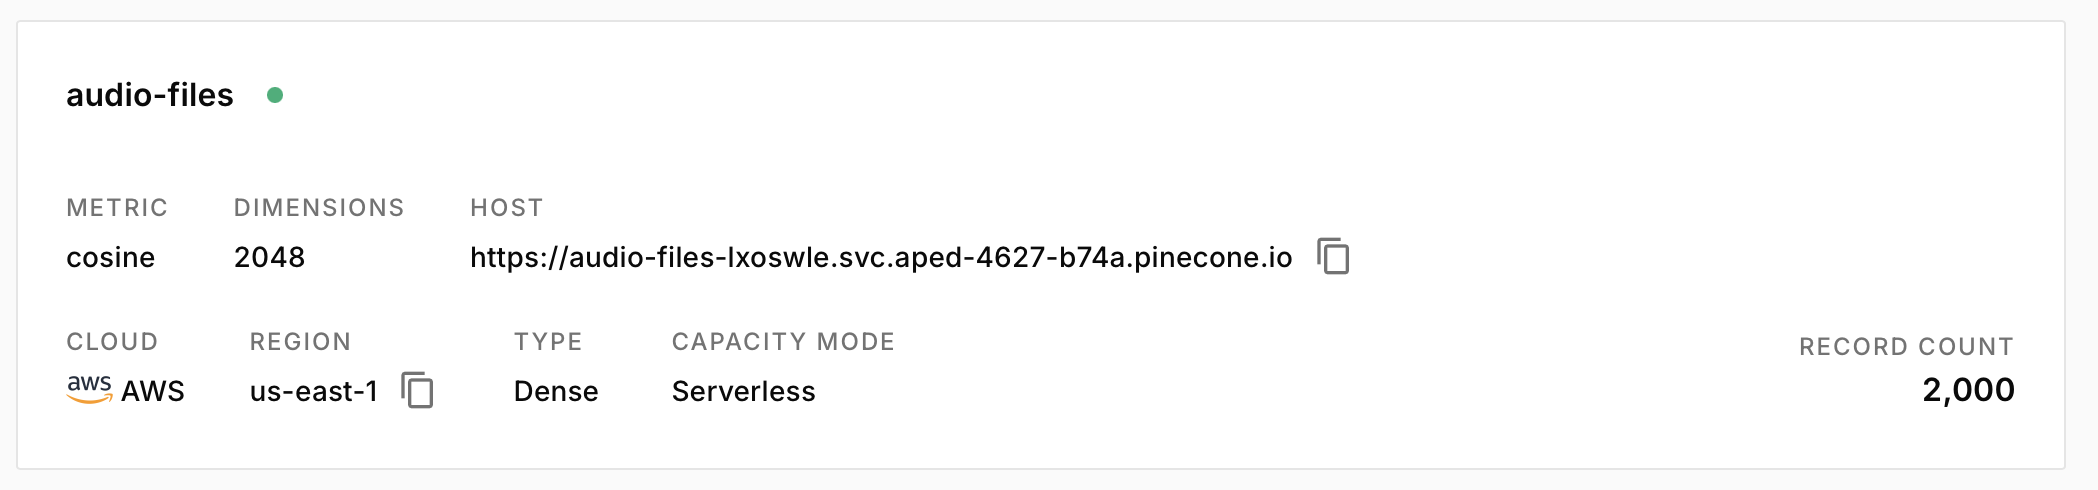

# 7. Audio Search with an Example from the Dataset

Now that we’ve stored all our audio embeddings in Pinecone, we can try searching the index to see how well our system retrieves similar sounds. For this first test, we’ll keep things simple by using in-sample data. That means our query audio will come directly from the same dataset we used to build the index.

This is a useful sanity check because the query clip itself should appear as the top match and other high-scoring results should come from the same sound category.

Let's pick one audio file from "resampled_data" so we can hear what we are searching for:

In [ ]:
# Playing the sound
sound_num = 390
query_clip = resampled_data[sound_num]
query_wave = query_clip["audio"]["array"].astype("float32")
sr = query_clip["audio"]["sampling_rate"]
print(f"Query category: {query_clip['category']} | filename: {query_clip['filename']} | sr: {sr}")
ipd.Audio(query_wave, rate=sr)

Now we'll compute the embedding for this single clip:

In [ ]:
_, emb = model.inference(query_wave[None, :])
query_vector = emb[0].tolist()
len(query_vector)

Now we'll request the top 5 most similar results along with their metadata:

In [ ]:
# Search for similar results
responses = index.query(
    vector = query_vector,
    top_k = 3,
    include_metadata = True
)

Let's print responses:
- The top result ("1-96950-A-9.wav") is an exact match to the query, which is why its similarity score is exactly 1.
- The next two results (IDs "1-96950-B-9.wav" and "2-108766-A-9.wav") are also labeled as "crow" and have high similarity scores, meaning their embeddings are very close to the query vector.

In [ ]:
for response in responses["matches"]:
    print(f"ID: {response['id']}")
    print(f"Score: {response['score']:.4f}")  # 4 decimal places
    metadata = response.get("metadata", {})
    print("Metadata:")
    for key, value in metadata.items():
            print(f" {key}: {value}")
    print("\n" + "-" * 40 + "\n")

### 📝 EXERCISE 2: Find Similar Sounds (10 minutes)

**What you'll practice:** Performing audio similarity search using Pinecone.

**Your task:**
1. Choose a different audio file from the dataset as your query sound
2. Play the audio to hear what it sounds like
3. Compute the embedding for this query audio
4. Search the Pinecone index for the top 3 most similar sounds
5. Print the results showing filenames and similarity scores
6. Optional: Play the top match to verify it sounds similar

**Hint:** You'll need to:
- Extract audio from the dataset: `resampled_data[your_index]`
- Compute embedding: `model.inference(audio[None, :])`
- Query Pinecone: `index.query(vector=embedding.tolist(), top_k=3, include_metadata=True)`

**Expected outcome:** The search should return sounds that are acoustically similar. The top result might even be the exact same file if it's in the database!

In [ ]:
# YOUR CODE HERE
# Example solution structure:
# 
# # Step 1: Choose and play audio
# query_idx = 100  # Choose your index
# query_audio = resampled_data[query_idx]["audio"]["array"]
# print(f"Query sound: {resampled_data[query_idx]['filename']}")
# # ipd.Audio(query_audio, rate=32000)  # Uncomment to play
# 
# # Step 2: Compute embedding
# _, query_embedding = model.inference(query_audio[None, :])
# 
# # Step 3: Search
# results = index.query(
#     vector=query_embedding.tolist(),
#     top_k=3,
#     include_metadata=True
# )
# 
# # Step 4: Display results
# print("\nTop 3 similar sounds:")
# for i, match in enumerate(results["matches"], 1):
#     print(f"{i}. {match['metadata']['filename']} - Score: {match['score']:.4f}")

We can also play the top matches to confirm that similar sounds are being retrieved:

In [ ]:
filename_to_idx = {fn: i for i, fn in enumerate(resampled_data["filename"])}

for m in responses["matches"][:3]:
    fn = m["id"]                        # filename string
    idx = filename_to_idx[fn]           # row index in resampled_data
    ex = resampled_data[idx]
    print(ex["category"], "|", ex["filename"], "| score:", f"{m['score']:.3f}")
    display(Ipa(ex["audio"]["array"], rate = ex["audio"]["sampling_rate"]))

# 8. Audio Search with a New Sound

In the second example, we'll use an external audio file "frog.wav", which should be placed in the same directory as this notebook, to search database for similar sounds. We first load the audioWe and resample it to 32 kHz so it matches the PANNs model’s training setup.

In [ ]:
own_audio, sample_rate = librosa.load("frogs.wav", sr = 32000)

In [ ]:
ipd.Audio(own_audio, rate = sample_rate)

Then we convert the waveform into an embedding vector using our pretrained audio model:

In [ ]:
# Creating Embedding
_, emb = model.inference(own_audio[None, :])
query_vec = emb[0].tolist()
len(query_vec)

Next, we search Pinecone for top 3 similar sounds in the database:

In [ ]:
# Searching for similar results
responses = index.query(
    vector = query_vec,
    top_k = 3,
    include_metadata = True)

In [ ]:
# Printing the top matches
for response in responses["matches"]:
    print(f"ID: {response['id']}")
    print(f"Score: {response['score']:.4f}")
    metadata = response.get("metadata", {})
    print("Metadata:")
    for key, value in metadata.items():
            print(f" {key}: {value}")
    print("\n" + "-" * 40 + "\n")

We can of course play the retrieved sounds so we can hear how closely they match our query:

In [ ]:
filename_to_idx = {fn: i for i, fn in enumerate(resampled_data["filename"])}

for m in responses["matches"][:3]:
    fn = m["id"]                        # filename string
    idx = filename_to_idx[fn]           # row index in resampled_data
    ex = resampled_data[idx]
    print(ex["category"], "|", ex["filename"], "| score:", f"{m['score']:.3f}")
    display(Ipa(ex["audio"]["array"], rate = ex["audio"]["sampling_rate"]))